In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

In [2]:
loan_df = pd.read_csv('C:\\Users\\Daniel-Panovest\\Downloads\\python ultra\\files\data\\vehicle_loans_feat.csv', index_col='UNIQUEID')

In [3]:
#repeating previous binary classifier processess for evaluation 
cat_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSAL_MONTH', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']
loan_df[cat_cols] = loan_df[cat_cols].astype('category')

#drop first drops the first dummy column for each unique value (under a column). making where it is a true indicator identifiable through other columns
cols = ['STATE_ID', 'LTV', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE', 'DISBURSAL_MONTH', 'LOAN_DEFAULT']
loan_df_subset = pd.get_dummies(loan_df[cols], prefix_sep='_', drop_first=True)

x = loan_df_subset.drop(['LOAN_DEFAULT'], axis=1)
y = loan_df_subset['LOAN_DEFAULT']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
log_res = LogisticRegression(max_iter=200)
log_res.fit(x_train, y_train)

LogisticRegression(max_iter=200)

In [4]:
#using trained model to predit target classes and calculating accuracy
print(log_res.predict(x_test))
print('\n')
print(f'the model has an accuracy score of {log_res.score(x_test, y_test):0%}')

[0 0 0 ... 0 0 0]


the model has an accuracy score of 78.229075%


In [5]:
#using other model eval metrics, knowing accuracy isn't a reliable source of model accuracy
predictions = log_res.predict(x_test)

#y_test was unseen by the tranined binary classifier model and helps derive an unbiased estimate of our predictions real-world performance
conf_mat = confusion_matrix(y_test, predictions)
conf_mat

array([[36476,     1],
       [10151,     3]], dtype=int64)

true negatives (correct non-defaults): 36476
false positives (incorrect defaults): 1
false negatives (incorrect non-defaults): 10151
true positives (correct defaults): 3


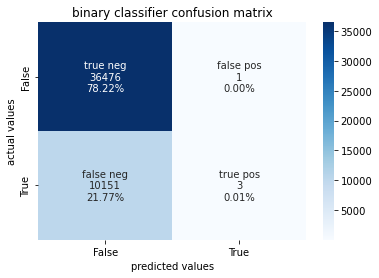

In [6]:
#extracting confusion matrix result using row and col index
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]

print(f'true negatives (correct non-defaults): {tn}')
print(f'false positives (incorrect defaults): {fp}')
print(f'false negatives (incorrect non-defaults): {fn}')
print(f'true positives (correct defaults): {tp}')

group_names = ['true neg', 'false pos', 'false neg', 'true pos']

#list comprehension to round total values to a whole number
#flatten allows elements in nested data structures (i.e list of lists/tuple of tuples) to be accessed in a single variable/sequentially without regard to its structure
group_counts = [f'{value:.0f}' for value in conf_mat.flatten()] 

#list comprehension to round group percentage to two decimal places
group_perct = [f'{value:.2%}' for value in conf_mat.flatten()/np.sum(conf_mat)]

labels = [f'{n}\n{c}\n{p}' for n, c, p in zip(group_names, group_counts, group_perct)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_mat, annot=labels, fmt='', xticklabels=['False','True'], yticklabels=['False','True'], cmap='Blues')
plt.title('binary classifier confusion matrix')
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

In [7]:
"""going by the purpose of this model, which is to predict loan defaults, 
this model has failed by predicting 78% of non-defaults instead; 
expectedly because 78% of the loans in the dataset were non-defaults. 
this forms a good example of where using accuracy for model valuation can be misleading"""

'going by the purpose of this model, which is to predict loan defaults, \nthis model has failed by predicting 78% of non-defaults instead; \nexpectedly because 78% of the loans in the dataset were non-defaults. \nthis forms a good example of where using accuracy for model valuation can be misleading'

In [8]:
"""using other model evaluation methods from the sklearn.metrics sub-module

precision returns a ratio of correctly predicted positives (tp) by total predicted positives (tp + fp)"""
precision = precision_score(y_test, predictions)

print(f'{precision:.0%} of the predictions were actually positive')

75% of the predictions were actually positive


In [9]:
recall = recall_score(y_test, predictions)

"""recall returns a ratio of correctly predicted positives (tp) by total actual positives (tp + fn)"""

print(f'{recall:.2%} of the actually positive predictions were correctly identified')

0.03% of the actually positive predictions were correctly identified


In [10]:
#f1_score is useful when a balance of precision and recall is required
f1 = f1_score(y_test, predictions)

print(f'the model has a f1 score of {f1:.4%}')
#the f1 score convincingly proves our model is unreliable despite having a high accuracy

the model has a f1 score of 0.0591%


In [11]:
"""using roc (receiver operating characteristic) to derive an auc (area under curve) value
a value close to 1.0 indictes a better overall performance. while 0.5 means the model suggests not more than a random performance""" 

#deriving target class prediciton probability
pred_prob = log_res.predict_proba(x_test)

#creating a dataframe for the target class prediction probability
pred_df = pd.DataFrame()
pred_df['prob_0'] = pred_prob[:, 0] #prediction probability for non-defaults
pred_df['prob_1'] = pred_prob[:, 1] #prediction probability for defaults

pred_df.describe()

,prob_0,prob_1
count,46631.000000,46631.000000
mean,0.783702,0.216298
std,0.067744,0.067744
min,0.480079,0.035123
25%,0.740025,0.169147
50%,0.787264,0.212736
75%,0.830853,0.259975
max,0.964877,0.519921


In [14]:
#the roc curve illustrates the trade-off between sensitivity (tpr) and specificity (fpr) in a classifier model

fpr, tpr, threshold = roc_curve(y_test, pred_prob[:, 1], pos_label=1) #pos label is the target class positive label

#creating a dataframe for readability
roc_df = pd.DataFrame()
roc_df['tpr'] = tpr
roc_df['fpr'] = fpr
roc_df['threshold'] = threshold

roc_df.describe()
#the new dataframe returns the tpr and fpr of our model while using different classification thresholds

,tpr,fpr,threshold
count,16426.000000,16426.000000,16426.000000
mean,0.524187,0.413037,0.231038
std,0.287564,0.275450,0.067371
min,0.000000,0.000000,0.035123
25%,0.275458,0.175056,0.185731
50%,0.535946,0.381501,0.227529
75%,0.774719,0.629109,0.271869
max,1.000000,1.000000,1.519921


In [23]:
#derviing auc value to determine model performance
roc_auc = auc(fpr, tpr)
print(f'the binary classifier model has an area under the curve value of {roc_auc:.2f}')

the binary classifier model has an area under the curve value of 0.61


In [38]:
"""an auc value slightly above 0.5 indicates the peformance of the model is close to
being random. meaning the model isn't effectively seperating the classes"""

#plotting the roc curve to visualize the area under the curve

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('reciever operating characteristic')
    plt.plot(fpr, tpr, 'b', label='auc %0.2f' %roc_auc)
    plt.legend(loc = 'upper left')
    plt.plot([0, 1], [0, 1],'r--') #plots a diagonal red dashed line representing a threshold
    plt.xlim([0, 1]) 
    plt.ylim([0, 1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


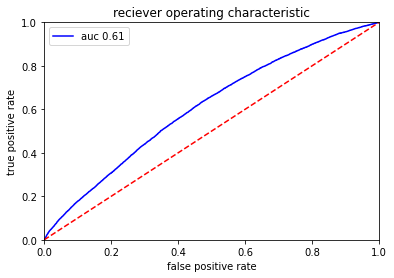

In [39]:
plot_roc_curve(fpr, tpr, roc_auc)

In [59]:
#advanced evaluation by inspecting target class splits and class probability distributions

results_df = pd.DataFrame()
results_df['true_class'] = y_test
results_df['predicted_class'] = list(predictions)
results_df['default_pred_prob'] = pred_prob[:, 1] #predicted probability of defualt (1) for the test set

#target class split against classifier predictions
results_df.groupby('true_class')['predicted_class'].value_counts().unstack(level=0)

#visibly, nearly all of the test cases were predicted as non-defaults

true_class,0,1
predicted_class,,
0,36476,10151
1,1,3


In [50]:
#deriving the model's probability of default for instances that are already non-defaults according to the test labels
def_pred_prob_false = results_df[results_df['true_class'] == 0]['default_pred_prob']
def_pred_prob_false

UNIQUEID
515702    0.179265
466872    0.205635
632384    0.279906
461426    0.178021
428779    0.190305
            ...   
507956    0.235077
546737    0.149120
636059    0.225354
512161    0.097623
626383    0.257858
Name: default_pred_prob, Length: 36477, dtype: float64

In [60]:
#deriving the model's probability of default for instances that are already defaults according to the test labels
def_pred_prob_true = results_df[results_df['true_class'] == 1]['default_pred_prob']
def_pred_prob_true

UNIQUEID
617183    0.284676
487121    0.123381
483207    0.328676
605634    0.154921
601565    0.269223
            ...   
603124    0.344984
491964    0.408357
609449    0.254512
437017    0.291511
503953    0.198931
Name: default_pred_prob, Length: 10154, dtype: float64

c:\Users\Daniel-Panovest\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\Daniel-Panovest\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


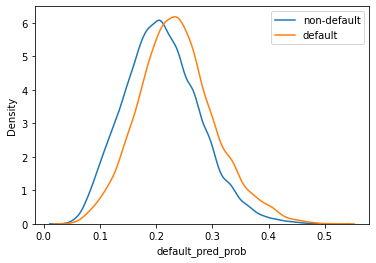

In [67]:
#using displot to visualize the class prediciton probability distributions
sns.distplot(def_pred_prob_false, label='non-default', hist=False)
sns.distplot(def_pred_prob_true, label='default', hist=False)
plt.legend(loc= 'best');

In [ ]:
"""despite the apparent poor linear separability, the evaluation reveals the probability of a defaulted being predicted as a 
default is higher than a non-default being predicted as one"""